# PS-matchning (1:1 Nearest Neighbor + caliper på logit(PS))
Denna notebook implementerar propensity score matching mellan CCI>5 (treated) och CCI≤5 (control) med 1:1 nearest neighbor utan replacement och caliper på logit(PS).


In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))
print("PROJECT_ROOT =", PROJECT_ROOT)

from src.connect_db import run_query, close_tunnel

PROJECT_ROOT = C:\Users\enaam\exjobb


c:\Users\enaam\.conda\envs\mimicenv\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\enaam\.conda\envs\mimicenv\Lib\site-packages\paramiko\transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,
2026-02-03 14:17:37,151| ERROR   | Password is required for key C:\Users\enaam/.ssh\id_rsa


SSH-tunnel startad på lokal port: 57511


### Läs in kohort och kovariater från SQL

In [2]:
# --- Kohort/basdata ---
sql_path = PROJECT_ROOT / "sql" / "stroke_cci_ps_cohort.sql"
with open(sql_path, encoding="utf-8") as f:
    cohort_sql = f.read()
df_base = run_query(cohort_sql)

print("df_base kolumner:", df_base.columns.tolist())
print("df_base rader:", len(df_base))

# --- Kovariater (first 24h) ---
sql_path = PROJECT_ROOT / "sql" / "stroke_covariates_first24h.sql"
with open(sql_path, encoding="utf-8") as f:
    cov_sql = f.read()
df_cov = run_query(cov_sql)

print("df_cov kolumner:", df_cov.columns.tolist())
print("df_cov rader:", len(df_cov))


df_base kolumner: ['subject_id', 'hadm_id', 'admittime', 'gender', 'anchor_age', 'dod', 'died', 'died_30d', 'died_90d', 'died_1y', 'cci_score', 'high_cci']
df_base rader: 4747
df_cov kolumner: ['subject_id', 'hadm_id', 'admittime', 'anchor_age', 'gender', 'creatinine_first', 'glucose_first', 'sodium_first', 'bun_first', 'bun_cr_ratio_first', 'has_creatinine', 'has_glucose', 'has_sodium', 'has_bun']
df_cov rader: 4747


## Merge och definiera variabler
Vi sammanfogar basdata och 24h-kovariater med en stabil nyckel och skapar en binär könsvariabel.

### Merge + kolumnval

In [3]:
candidate_keys = ["stay_id", "subject_id", "hadm_id"]
keys_in_both = [k for k in candidate_keys if k in df_base.columns and k in df_cov.columns]
print("Keys i båda:", keys_in_both)

if "stay_id" in keys_in_both:
    merge_keys = ["stay_id"]
elif all(k in keys_in_both for k in ["subject_id", "hadm_id"]):
    merge_keys = ["subject_id", "hadm_id"]
elif "hadm_id" in keys_in_both:
    merge_keys = ["hadm_id"]
else:
    raise ValueError(f"Hittar inga rimliga merge-keys. Keys i båda: {keys_in_both}")

print("Merge keys:", merge_keys)

df = df_base.merge(df_cov, on=merge_keys, how="left")
print("Efter merge:", df.shape)

Keys i båda: ['subject_id', 'hadm_id']
Merge keys: ['subject_id', 'hadm_id']
Efter merge: (4747, 24)


### Variabeldefinitioner (Välj kolumner robust) 

In [4]:
# Treatment
TREAT_COL = "high_cci"  # 1 = CCI>5, 0 = CCI≤5

# Ålder/kön kan heta anchor_age eller anchor_age_x beroende på merge
AGE_COL = "anchor_age" if "anchor_age" in df.columns else ("anchor_age_x" if "anchor_age_x" in df.columns else None)
GENDER_COL = "gender" if "gender" in df.columns else ("gender_x" if "gender_x" in df.columns else None)

if AGE_COL is None or GENDER_COL is None:
    raise ValueError(f"Hittar inte ålder/kön. AGE_COL={AGE_COL}, GENDER_COL={GENDER_COL}")

# Labs
GLU_COL = "glucose_first"
NA_COL  = "sodium_first"
CR_COL  = "creatinine_first"
BUN_COL = "bun_first"

# Outcomes
OUTCOMES = [c for c in ["died_30d", "died_90d", "died_1y"] if c in df.columns]

need_exist = [TREAT_COL, AGE_COL, GENDER_COL, GLU_COL, NA_COL, CR_COL, BUN_COL]
missing = [c for c in need_exist if c not in df.columns]
if missing:
    raise ValueError(f"Saknar kolumner i df: {missing}")

print("AGE_COL:", AGE_COL, "GENDER_COL:", GENDER_COL)
print("OUTCOMES:", OUTCOMES)


AGE_COL: anchor_age_x GENDER_COL: gender_x
OUTCOMES: ['died_30d', 'died_90d', 'died_1y']


### Bygg df_model (komplettfall) + PS

In [5]:
# Skapa binär kön
df["is_male"] = (
    df[GENDER_COL].astype(str).str.strip().str.upper()
      .isin(["M", "MALE", "MAN"])
      .astype(int)
)
SEX_COL = "is_male"

cov_need = [TREAT_COL, AGE_COL, SEX_COL, GLU_COL, NA_COL, CR_COL, BUN_COL]
df_model = df.dropna(subset=cov_need).copy()

df_model["treat"] = df_model[TREAT_COL].astype(int)
# Säkerställ att treat är binär (0/1)
u = set(df_model["treat"].dropna().unique())
if not u.issubset({0, 1}):
    raise ValueError(f"treat är inte binär 0/1. Unika värden: {sorted(u)}") 
# log1p-transform för BUN och kreatinin (för PS)
df_model["log_creatinine"] = np.log1p(df_model[CR_COL].astype(float))
df_model["log_bun"]        = np.log1p(df_model[BUN_COL].astype(float))

covs = [AGE_COL, SEX_COL, GLU_COL, NA_COL, "log_creatinine", "log_bun"]

X = df_model[covs].astype(float).values
t = df_model["treat"].values

psm = LogisticRegression(max_iter=5000, solver="lbfgs")
psm.fit(X, t)

ps = np.clip(psm.predict_proba(X)[:, 1], 1e-6, 1-1e-6)
df_model["ps"] = ps
df_model["logit_ps"] = np.log(ps/(1-ps))

print("df_model:", df_model.shape)
print("treat counts:\n", df_model["treat"].value_counts())
print(df_model.groupby("treat")["ps"].describe()[["min","max","mean","std"]])


df_model: (4271, 30)
treat counts:
 treat
0    3670
1     601
Name: count, dtype: int64
            min       max      mean       std
treat                                        
0      0.014770  0.937602  0.122944  0.107187
1      0.028806  0.952581  0.249246  0.181035


### 1:1 Nearest Neighbor-matchning med caliper
Matchning görs utan replacement med caliper = 0.2 × SD(logit(PS)).


In [6]:
caliper = 0.2 * df_model["logit_ps"].std(ddof=1)
print("Caliper:", caliper)

T = df_model[df_model["treat"] == 1].copy().sort_values("logit_ps", ascending=False)
C = df_model[df_model["treat"] == 0].copy()

nn = NearestNeighbors(n_neighbors=min(50, len(C)))
nn.fit(C[["logit_ps"]].values)

used_controls = set()
pairs = []
unmatched = 0

for tidx, tr in T.iterrows():
    dists, idxs = nn.kneighbors([[tr["logit_ps"]]], return_distance=True)
    found = False
    for d, j in zip(dists[0], idxs[0]):
        cidx = C.index[int(j)]
        if cidx in used_controls:
            continue
        if float(d) <= caliper:
            used_controls.add(cidx)
            pairs.append((tidx, cidx, float(d)))
            found = True
            break
    if not found:
        unmatched += 1

n_pairs = len(pairs)
match_rate = n_pairs / len(T) if len(T) else np.nan

print("Matchade par:", n_pairs)
print("Unmatched treated:", unmatched)
print("Matchningsgrad:", round(match_rate, 4))

if n_pairs == 0:
    raise ValueError("Inga matchade par skapades (kontrollera overlap/caliper).")

mt = [p[0] for p in pairs]
mc = [p[1] for p in pairs]

df_t = df_model.loc[mt].copy()
df_c = df_model.loc[mc].copy()
df_t["match_group"] = range(n_pairs)
df_c["match_group"] = range(n_pairs)

df_matched = (
    pd.concat([df_t, df_c], axis=0)
      .sort_values(["match_group", "treat"])
      .reset_index(drop=True)
)

print("df_matched:", df_matched.shape)
print(df_matched["treat"].value_counts())


Caliper: 0.17235396023028857
Matchade par: 599
Unmatched treated: 2
Matchningsgrad: 0.9967
df_matched: (1198, 31)
treat
0    599
1    599
Name: count, dtype: int64


### Kovariatbalans före/efter (SMD)
Vi beräknar Standardized Mean Difference för samma kovariater som ingick i PS-modellen.


,covariate,SMD_pre,SMD_post,|SMD_pre|,|SMD_post|
5,log_bun,0.909651,-0.049468,0.909651,0.049468
4,log_creatinine,0.848956,0.098353,0.848956,0.098353
2,glucose_first,0.287311,0.056086,0.287311,0.056086
0,anchor_age_x,0.150500,-0.133384,0.150500,0.133384
3,sodium_first,-0.109782,-0.023965,0.109782,0.023965
1,is_male,0.104833,-0.037035,0.104833,0.037035


Max |SMD| före : 0.909651396257865
Max |SMD| efter: 0.13338403041544694


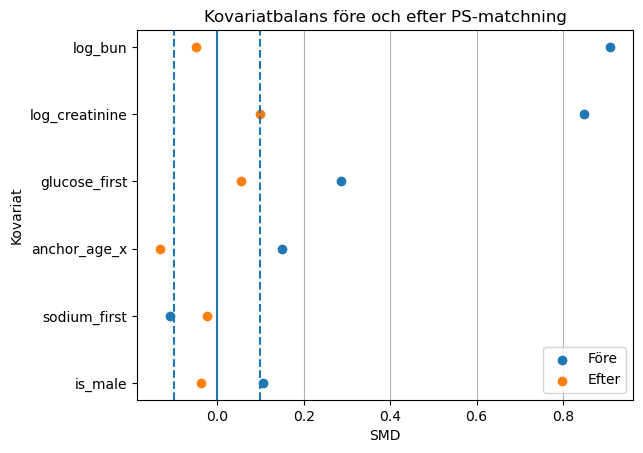

In [7]:
def smd_signed(df_in, col, treat_col="treat"):
    a = df_in[df_in[treat_col] == 1][col].astype(float)
    b = df_in[df_in[treat_col] == 0][col].astype(float)
    sp = np.sqrt((a.var(ddof=1) + b.var(ddof=1)) / 2)
    if sp == 0 or np.isnan(sp):
        return 0.0
    return (a.mean() - b.mean()) / sp

smd_tbl = pd.DataFrame({
    "covariate": covs,
    "SMD_pre":  [smd_signed(df_model, c) for c in covs],
    "SMD_post": [smd_signed(df_matched, c) for c in covs],
})
smd_tbl["|SMD_pre|"]  = smd_tbl["SMD_pre"].abs()
smd_tbl["|SMD_post|"] = smd_tbl["SMD_post"].abs()

display(smd_tbl.sort_values("|SMD_pre|", ascending=False))
print("Max |SMD| före :", smd_tbl["|SMD_pre|"].max())
print("Max |SMD| efter:", smd_tbl["|SMD_post|"].max())

# Love-plot enkel
plot_df = smd_tbl.sort_values("|SMD_pre|", ascending=True).reset_index(drop=True)
y = np.arange(len(plot_df))

plt.figure()
plt.scatter(plot_df["SMD_pre"],  y, label="Före")
plt.scatter(plot_df["SMD_post"], y, label="Efter")
plt.axvline(0)
plt.axvline(0.1, linestyle="--")
plt.axvline(-0.1, linestyle="--")
plt.yticks(y, plot_df["covariate"])
plt.xlabel("SMD")
plt.ylabel("Kovariat")
plt.title("Kovariatbalans före och efter PS-matchning")
plt.legend()
plt.grid(True, axis="x")
plt.show()


### Utfallstabeller
Vi redovisar antal döda per grupp i den matchade populationen.


### Risk före/efter (rapporttabell)
Vi sammanställer N, döda och risk% före och efter matchning för varje utfall.


In [8]:
def deaths_table_pre_post(df_pre, df_post, outcomes):
    rows = []
    for oc in outcomes:
        dpre = df_pre.dropna(subset=[oc]).copy()
        dpost = df_post.dropna(subset=[oc]).copy()

        for dset, tag in [(dpre, "Före"), (dpost, "Efter")]:
            n0 = int((dset["treat"]==0).sum())
            n1 = int((dset["treat"]==1).sum())
            dead0 = int(dset.loc[dset["treat"]==0, oc].sum())
            dead1 = int(dset.loc[dset["treat"]==1, oc].sum())
            r0 = 100*dead0/n0 if n0 else np.nan
            r1 = 100*dead1/n1 if n1 else np.nan

            rows.append({
                "Outcome": oc,
                "Status": tag,
                "N (CCI≤5)": n0,
                "Döda (CCI≤5)": dead0,
                "Risk% (CCI≤5)": r0,
                "N (CCI>5)": n1,
                "Döda (CCI>5)": dead1,
                "Risk% (CCI>5)": r1,
            })

    out = pd.DataFrame(rows)
    out[["Risk% (CCI≤5)", "Risk% (CCI>5)"]] = out[["Risk% (CCI≤5)", "Risk% (CCI>5)"]].round(2)
    return out

df_deaths = deaths_table_pre_post(df_model, df_matched, OUTCOMES)
display(df_deaths)


,Outcome,Status,N (CCI≤5),Döda (CCI≤5),Risk% (CCI≤5),N (CCI>5),Döda (CCI>5),Risk% (CCI>5)
0,died_30d,Före,3670,516,14.06,601,159,26.46
1,died_30d,Efter,599,132,22.04,599,159,26.54
2,died_90d,Före,3670,719,19.59,601,220,36.61
3,died_90d,Efter,599,178,29.72,599,220,36.73
4,died_1y,Före,3670,961,26.19,601,308,51.25
5,died_1y,Efter,599,221,36.89,599,307,51.25
